# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

4423680/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
    
    def get_sigma(self):
        sample_size = 1000000
        i_s = np.random.randint(self.X.shape[0], size=sample_size)
        j_s = np.random.randint(self.X.shape[0], size=sample_size)
        all = np.sum((self.X[i_s, :] - self.X[j_s, :]) ** 2, axis=1)
        return np.median(all)

    def fit_PCA(self):
        if (self.use_PCA):
            self.PCA_model = PCA(n_components=self.new_dim, copy=True, whiten=True)
            self.X = self.PCA_model.fit_transform(self.X)

        return self
    
    def transform_PCA(self):
        if (self.use_PCA):
            self.X = self.PCA_model.transform(self.X)

        return self

    def generate_new_features(self):
        self.sigma = self.get_sigma()
        self.features_w = np.random.normal(0, 1. / self.sigma, size=(self.n_features, self.X.shape[1]))
        self.features_b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return self

    def apply_new_features(self):
        self.X = np.cos(np.dot(self.X, self.features_w.T) + self.features_b)
        return self

    def fit_base_model(self):
        if self.classifier == "svm":
            self.base_model = SVC(probability=True)
        if self.classifier == "logreg":
            self.base_model = LogisticRegression()
        
        self.base_model.fit(self.X, self.y)
        return self

    def predict_base_model(self):
        return self.base_model.predict_proba(self.X)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.X = X.copy()
        self.y = y.copy()
        return self.fit_PCA().generate_new_features().apply_new_features().fit_base_model()

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        self.X = X.copy()
        return self.transform_PCA().apply_new_features().predict_base_model()
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        self.X = X.copy()
        return np.argmax(self.predict_proba(X), axis=1)

Потестируем

In [ ]:
from sklearn.metrics import accuracy_score
import time

# Возвращает модели с которых делать замеры
def get_models():
    return [
        ("RFFPipeline logreg use_PCA=True", RFFPipeline(classifier="logreg")),
        # ("RFFPipeline svm   ", RFFPipeline(classifier="svm")),
    ]

models = get_models()

for model_name, model in models:
    start = time.time()
    model = model.fit(x_train, y_train)
    end = time.time()
    print("Time: ", end - start)
    y_test_pred = model.predict(x_test)
    print(model_name, "test  score =", accuracy_score(y_test, y_test_pred))


Time:  67.35263681411743
RFFPipeline logreg use_PCA=True test  score = 0.8151


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
from sklearn.metrics import accuracy_score
import time
# Возвращает модели с которых делать замеры
def get_models():
    return [
        ("SVC lenial", SVC(kernel="linear", probability=True)),
        ("SVC kernel", SVC(probability=True)),
        # ("RFFPipeline svm   ", RFFPipeline(classifier="svm")),
    ]

models = get_models()

for model_name, model in models:
    sub_size = 10000
    i_s = np.random.choice(x_train.shape[0], sub_size)
    start = time.time()
    model = model.fit(x_train[i_s, :], y_train[i_s])
    end = time.time()
    y_test_pred = model.predict(x_test)
    print(model_name, "test  score =", accuracy_score(y_test, y_test_pred))
    print("Time: ", end - start)


SVC lenial test  score = 0.7928
Time:  155.1386113166809
SVC kernel test  score = 0.853
Time:  185.60704708099365


**Вывод**: 
Чтобы хватило терпения дождаться пока отработает SVM пришлось уменьшить train выборку в 6 раз. В итоге все равно работает в 3 рада дольше логистической регрессии. Точность у линейного SVM получилась хуже, а у ядрового SVM получилась лучше чем у логистической регрессии. Похоже на правду, ядровой SVM внутри сам ищет сложные завивимости и строит нелинейное разделение. Логистическая регрессия лучше линейного разделения также потому что она умеет находить более сложные зависимости. 

Переберем параметры для xgboost. Поищем параметры на подвыборке из 10000 элементов

In [ ]:
import xgboost as xgb

PCA_model = PCA(n_components=50, copy=True, whiten=True).fit(x_train)

sub_size = 10000
i_s = np.random.choice(x_train.shape[0], sub_size)

dtrain = xgb.DMatrix(data=PCA_model.transform(x_train[i_s, :]), label=y_train[i_s])
dtest = xgb.DMatrix(data=PCA_model.transform(x_test), label=y_test)

for nr in [16, 32, 64, 128]:
    print("num_round =", nr)
    for eta in [0.03, 0.1, 0.3]:
        print("\teta =", eta)
        param = {'max_depth': 6, 'eta': eta, 'objective': 'multi:softmax', 'num_class': 10, "eval_metric": "merror", "subsample": 0.5}
        watchlist = [] #[(dtest, 'test')]
        num_round = nr
        
        start = time.time()
        bst = xgb.train(param, dtrain, num_round, watchlist)
        end = time.time()

        preds = bst.predict(dtest)
        y_test_pred = np.array(preds, dtype=int)

        print(f"\t\ttest score =", accuracy_score(y_test, y_test_pred), "time =", end - start)

num_round = 16
	eta = 0.03
		test score = 0.799 time = 7.0715718269348145
	eta = 0.1
		test score = 0.8063 time = 6.988680601119995
	eta = 0.3
		test score = 0.821 time = 6.819857358932495
num_round = 32
	eta = 0.03
		test score = 0.8037 time = 13.89285683631897
	eta = 0.1
		test score = 0.8184 time = 13.685903787612915
	eta = 0.3
		test score = 0.829 time = 13.409934043884277
num_round = 64
	eta = 0.03
		test score = 0.8128 time = 27.749443531036377
	eta = 0.1
		test score = 0.8327 time = 26.86726999282837
	eta = 0.3
		test score = 0.8353 time = 25.317675352096558
num_round = 128
	eta = 0.03
		test score = 0.8259 time = 54.59404420852661
	eta = 0.1
		test score = 0.841 time = 52.717243671417236
	eta = 0.3
		test score = 0.8407 time = 44.84522223472595


Лучшие параметры получились  **eta=0.1**, **num_round=64** (128 не сильно точнее, но работает в 2 раза дольше)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=PCA_model.transform(x_train), label=y_train)
dtest = xgb.DMatrix(data=PCA_model.transform(x_test), label=y_test)

param = {'max_depth': 6, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': 10, "eval_metric": "merror", "subsample": 0.5}
num_round = 64
        
start = time.time()
bst = xgb.train(param, dtrain, num_round, watchlist)
end = time.time()

preds = bst.predict(dtest)
y_test_pred = np.array(preds, dtype=int)

print(f"xgboost", "test score =", accuracy_score(y_test, y_test_pred))
print("Time: ", end - start)

xgboost test score = 0.8508
Time:  178.90177130699158


**Вывод**:
Ядровой SVM получил примерно такую же точность как бустинг. Но при этом обучали мы бустинг на всех данных, а SVM на 15% данных. 
Точность 0.8 бустинг получает буквально за несколько секунд. Кажется что бустинг потенциально можно было лучше подкрутить. 

С другой стороны бустинг мы обучали на 50 признаках, а SVM на 1000. Как мы выясним в следующем задании попытка делать меньше признаков в SVM не всегда приносит успех. 

Также в SVM и бустинге чтобы достичь хорошей точности "крутить" нужно разные параметры. Что проще перебирать вопрос философский. Но если положиться на "накопившуюся мудрость поколений" и поставить параметры, близкие к параметрам по умолчанию, то бустинг уже работает хорошо и быстрее чем SVM. 

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1.

In [ ]:
def get_models():
    return 

models = [("RFFPipeline logreg use_PCA=False", RFFPipeline(classifier="logreg", use_PCA=False))]

for model_name, model in models:
    start = time.time()
    model = model.fit(x_train, y_train)
    end = time.time()
    print("Time: ", end - start)
    y_test_pred = model.predict(x_test)
    print(model_name, "test  score =", accuracy_score(y_test, y_test_pred))


Time:  65.34850883483887
RFFPipeline logreg use_PCA=False test  score = 0.7839


**Вывод**: Получили результат хуже чем с PCA. Однозначно понижение размерности это неплохое решение.

2.

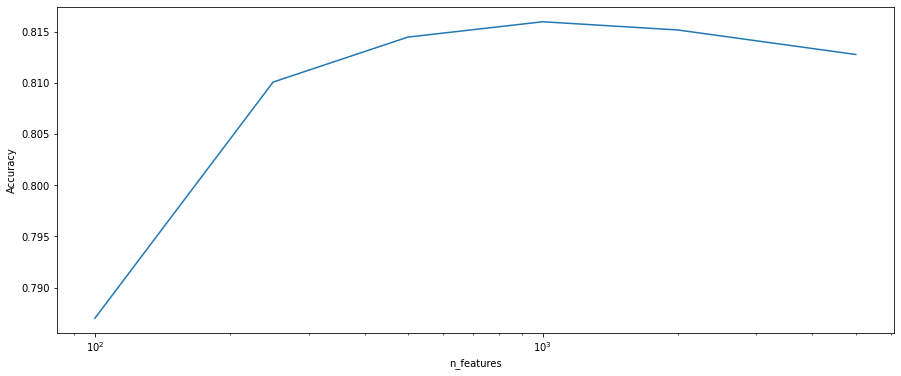

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

xs = [100, 250, 500, 1000, 2000, 5000]
ys = []

ax.set_xscale("log")

for n_features in xs: 
    model = RFFPipeline(classifier="logreg", n_features=n_features)
    model = model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    test_score = accuracy_score(y_test, y_test_pred)
    ys.append(test_score)

ax.plot(xs, ys)
ax.set_xlabel("n_features")
ax.set_ylabel("Accuracy")
plt.show()

**Вывод**: Картина интересная. Лучшая точность как раз получается в районе 1000, то что мы использовали в нашей модели. Дальше точность начинает падать, хотя и несильно. Возможно проблема в том что логистическая регрессия не успевает подкрутиться когда признаков слишком много, и как решение можно было бы попробовать увеличить количество итераций для логистической регресии. 

Итак, с увеличением n_features точность растет, но как видно достаточно хорошо разрулить 1000 признаков, а не лезть тонуть в 5 тысячах, потому что там то же самое.

3.

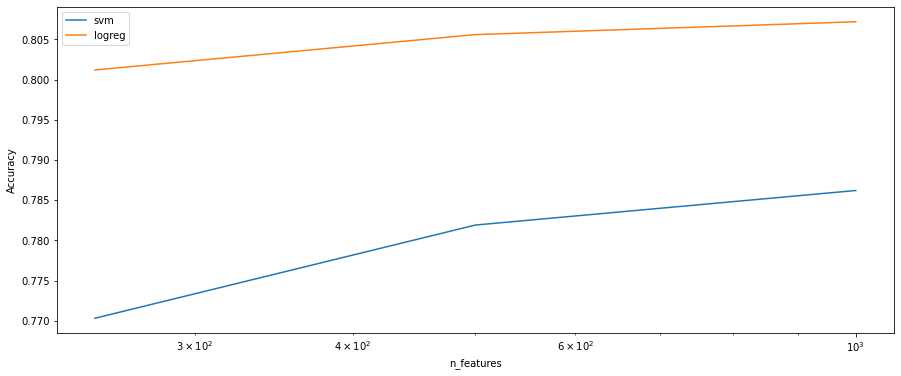

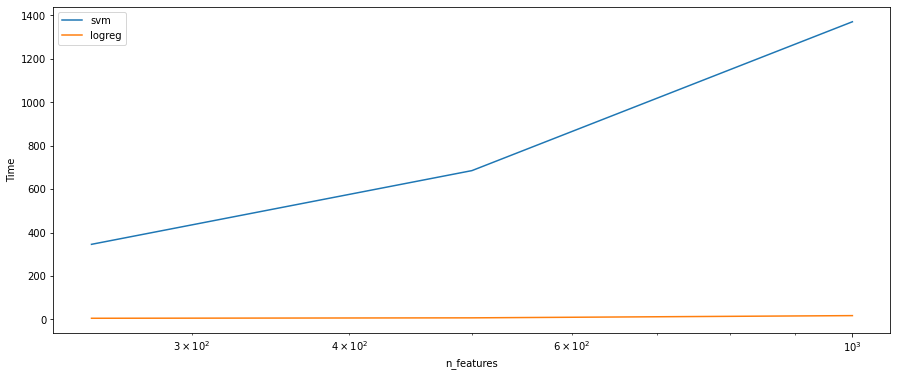

In [ ]:


fig, ax = plt.subplots(figsize=(15, 6))
fig_time, ax_time = plt.subplots(figsize=(15, 6))

ax.set_xscale("log")
ax_time.set_xscale("log")

sub_size = 10000
i_s = np.random.choice(x_train.shape[0], sub_size)

for classifier in ["svm", "logreg"]:
    xs = [250, 500, 1000]
    ys = []
    ys_time = []

    for n_features in xs: 
        
        start = time.time()
        model = RFFPipeline(classifier=classifier, n_features=n_features)
        model = model.fit(x_train[i_s, :], y_train[i_s])
        end = time.time()
        y_test_pred = model.predict(x_test)
        test_score = accuracy_score(y_test, y_test_pred)
        ys.append(test_score)
        ys_time.append(end - start)
        
    ax.plot(xs, ys, label=f"{classifier}")
    ax_time.plot(xs, ys_time, label=f"{classifier}")

ax.set_xlabel("n_features")
ax.set_ylabel("Accuracy")
ax_time.set_xlabel("n_features")
ax_time.set_ylabel("Time")
ax.legend()
ax_time.legend()
fig.show()
fig_time.show()

**Вывод**: SVM работает долго, и стабильно хуже. Это видно на графиках выше. В данном случае логистическая регрессия справилась лучше.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [14]:
class ORFPipeline(RFFPipeline):
    def generate_new_features_batch(self, d):
        S = np.sqrt(np.random.chisquare(d, size=d))
        Q, _ = np.linalg.qr(np.random.normal(0, 1, size=(d, d)))
        return np.dot(np.diag(S), Q)

    def generate_new_features(self):
        self.sigma = self.get_sigma()
        
        D = self.n_features
        d = self.X.shape[1]
        self.features_w = None

        while D > 0:
            add = min(D, d)
            cur = self.generate_new_features_batch(d)[0:add, :]
            if not (self.features_w is None):
                self.features_w = np.append(self.features_w, cur, axis=0)
            else:
                self.features_w = cur
            D -= add

        self.features_w /= self.sigma
        self.features_b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return self
    
    def apply_new_features(self):
        self.X = np.cos(np.dot(self.X, self.features_w.T) + self.features_b)
        return self

In [13]:
from sklearn.metrics import accuracy_score
import time

# Возвращает модели с которых делать замеры
def get_models():
    return [
        ("OFFPipeline", ORFPipeline()),
        # ("RFFPipeline svm   ", RFFPipeline(classifier="svm")),
    ]

models = get_models()

for model_name, model in models:
    start = time.time()
    model = model.fit(x_train, y_train)
    end = time.time()
    print("Time: ", end - start)
    y_test_pred = model.predict(x_test)
    print(model_name, "test  score =", accuracy_score(y_test, y_test_pred))


Time:  64.11074209213257
OFFPipeline test  score = 0.8143


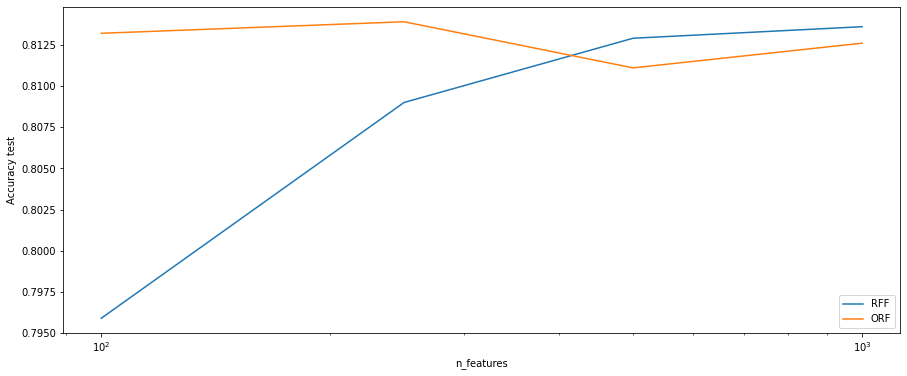

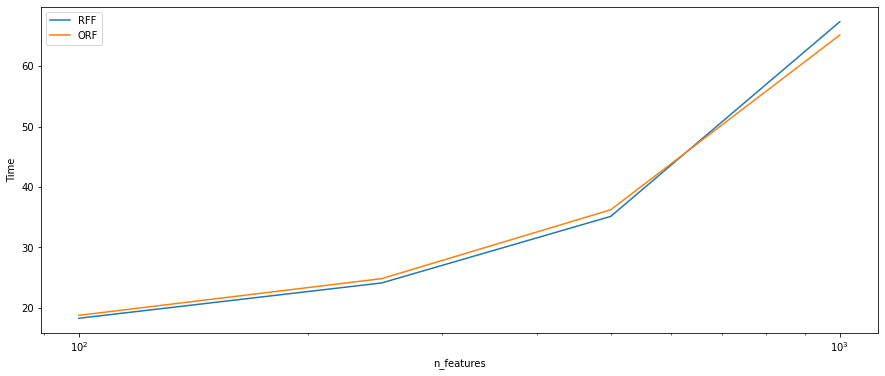

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
fig_time, ax_time = plt.subplots(figsize=(15, 6))

ax.set_xscale("log")
ax_time.set_xscale("log")

models = [
    ("RFF", RFFPipeline),
    ("ORF", ORFPipeline)
]
for name, model_name in models:
    xs = [100, 250, 500, 1000]
    ys = []
    ys_time = []

    for n_features in xs: 
        start = time.time()
        model = model_name(n_features=n_features)
        model = model.fit(x_train, y_train)
        end = time.time()
        y_test_pred = model.predict(x_test)
        test_score = accuracy_score(y_test, y_test_pred)
        ys.append(test_score)
        ys_time.append(end - start)
        
    ax.plot(xs, ys, label=f"{name}")
    ax_time.plot(xs, ys_time, label=f"{name}")

ax.set_xlabel("n_features")
ax.set_ylabel("Accuracy test")
ax_time.set_xlabel("n_features")
ax_time.set_ylabel("Time")
ax.legend()
ax_time.legend()
fig.show()
fig_time.show()

**Вывод**: ORF дает лучше точность при меньшем количестве новых фич. Начиная с 1000 разница перестает быть заметна. По времени обучения примерно одинаково.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [21]:
class RFFPipelineUpdated(RFFPipeline):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', new_features_transformer=np.cos):
        super(RFFPipelineUpdated, self).__init__(n_features=1000, new_dim=50, use_PCA=True, classifier='logreg')  
        self.new_features_transformer = new_features_transformer
    
    def apply_new_features(self):
        self.X = self.new_features_transformer(np.dot(self.X, self.features_w.T) + self.features_b)
        return self

class RFFPipelineUpdatedExtended(RFFPipeline):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', new_features_transformer=np.cos):
        super(RFFPipelineUpdatedExtended, self).__init__(n_features=1000, new_dim=50, use_PCA=True, classifier='logreg')  
        self.new_features_transformer = new_features_transformer
    
    def apply_new_features(self):
        self.X = self.new_features_transformer(np.dot(self.X, self.features_w.T), self.features_b)
        return self

In [23]:
import pandas as pd
from scipy.special import expit

#results = pd.DataFrame(columns=["Feature name", "Accuracy train", "Accuracy test", "Train time"])

models = [
    #("sign", RFFPipelineUpdated(new_features_transformer=np.sign)),
    #("expit", RFFPipelineUpdated(new_features_transformer=expit)),
    #("arctan", RFFPipelineUpdated(new_features_transformer=np.arctan)),
    #("signed sqrt", RFFPipelineUpdated(new_features_transformer=lambda x: np.sign(x) * np.sqrt(np.abs(x)))),
    #("signed sqr", RFFPipelineUpdated(new_features_transformer=lambda x: np.sign(x) * (x ** 2))),
    #("signed log", RFFPipelineUpdated(new_features_transformer=lambda x: np.sign(x) * (np.log(np.abs(x))))),
    #("signed exp", RFFPipelineUpdated(new_features_transformer=lambda x: np.sign(x) * (np.exp(np.abs(x))))),
    #("power 3", RFFPipelineUpdated(new_features_transformer=lambda x: x ** 3)),
    #("no transform", RFFPipelineUpdated(new_features_transformer=lambda x: x)),
    #("no b", RFFPipelineUpdatedExtended(new_features_transformer=lambda x, b: x)),
    #("signed sqr, no b", RFFPipelineUpdatedExtended(new_features_transformer=lambda x, b: np.sign(x) * (x ** 2))),
]

for feature_name, model in models:
    print(feature_name)
    start = time.time()
    model = model.fit(x_train, y_train)
    end = time.time()
    test_score = accuracy_score(y_test, model.predict(x_test))
    train_score = accuracy_score(y_train, model.predict(x_train))
    add = {
        "Feature name": feature_name, 
        "Accuracy train": train_score, 
        "Accuracy test": test_score, 
        "Train time": end - start,
    }
    results = results.append(add, ignore_index=True)

results

signed sqr, no b


,Feature name,Accuracy train,Accuracy test,Train time
0,sign,0.585250,0.5795,67.783567
1,expit,0.819050,0.8075,67.988628
2,arctan,0.816583,0.8048,67.308063
3,signed sqrt,0.815950,0.8025,66.434975
4,signed sqr,0.825917,0.8156,66.879897
5,signed log,0.799133,0.7833,68.286261
6,signed exp,0.821583,0.8093,67.275313
7,power 3,0.820800,0.8079,71.319558
8,no transform,0.822717,0.8090,65.066599
9,no b,0.838733,0.8260,68.980891


**Вывод**: Результат улучшился от начального (~0.815) примерно на 0.01. Сработало генерировать новые фичи как просто линейная комбинация существующих (в таблице "no b").